In [8]:
import pandas as pd
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.metrics import confusion_matrix, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import precision_score, f1_score


In [3]:
# read each part of data II

data_6p_t2m = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_t2m.csv')
data_6p_h2m = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_h2m.csv')

In [4]:
#combine data to get the complete data II

data_6p_combined = pd.concat([data_6p_t2m,data_6p_t2m])

In [5]:
data_6p_combined.to_csv('../datasets/data_6p_combined.csv', index=False)
data_heatmap = pd.read_csv('../datasets/data_6p_combined.csv')

### Training Data(old)

In [7]:
# read the training data of data I from datasets folder
!python3 pca_pipeline_combine_gridid.py 200 '../datasets/train/data_heatmap_train.csv'

pca_df = pd.read_csv('temp/pca_df.csv')
pca_df = pca_df.iloc[:,1:]
pca_df_inp = pca_df.iloc[:,:-2]
y_train = pca_df['label'].values

Nb components:  200
Data directory:  ../datasets/train/data_heatmap_train.csv


### Test Data(new)

In [6]:
# read the test data -- data II from datasets folder
!python3 pca_pipeline_combine_gridid.py 200 '../datasets/data_6p_combined.csv'

pca_test = pd.read_csv('temp/pca_df.csv')
pca_test = pca_test.iloc[:,1:]
y_test = pca_test[['label']].values

Nb components:  200
Data directory:  ../datasets/data_6p_combined.csv


### SVM

In [9]:
# from unsupervised_models_dataI_train&test_clean.ipynb, the best model uses 172 PCA dimensions
pca_dim = 172

X_train = pca_df_inp.iloc[:,:pca_dim]
X_test = pca_test.iloc[:,:pca_dim]

# fit on training data of data I
oneclass = OneClassSVM(gamma = 'auto').fit(X_train)
# test on test data (data II)
oneclass_labels = oneclass.predict(X_test)
    
oneclass_labels = np.where(oneclass_labels == 1, 0,1)
conf_mat   = confusion_matrix(y_test,oneclass_labels)
acc        = accuracy_score(y_test,oneclass_labels)
recall     = recall_score(y_test,oneclass_labels)
prec       = precision_score(y_test,oneclass_labels)
f1         = f1_score(y_test,oneclass_labels, average='macro')

print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
              f' {conf_mat}')
print(f'F1 Score for {pca_dim} PCA dimensions:', 
              f' {f1:.2f}')

Confusion matrix for 172 PCA dimensions:
  [[308 475]
 [  8   5]]
F1 Score for 172 PCA dimensions:  0.29


### KNN

In [13]:
# Perform PCA on X_train and X_test with 10 dimensions
PCA = 10
nn = 10
thres = 90

X_train = pca_df_inp.iloc[:, :PCA]  
X_test = pca_test.iloc[:, :PCA] 

# Train k-NN model on X_train_pca with 10 neighbors
knn = NearestNeighbors()
knn.fit(X_train)

# Predict anomalies on X_test_pca
distances, indices = knn.kneighbors(X_test)
anomaly_scores = distances.mean(axis=1)
threshold = np.percentile(anomaly_scores, thres)

# Convert labels to binary (0: inliers, 1: outliers)
knn_labels = np.where(anomaly_scores > threshold, 1, 0)

# Evaluate the performance on X_test
conf_mat = confusion_matrix(y_test, knn_labels)
acc = accuracy_score(y_test, knn_labels)
f1 = f1_score(y_test, knn_labels, average='macro')

print(f'Confusion matrix on X_test:\n{conf_mat}')
print(f'Accuracy on X_test: {acc:.2f}')
print(f'F1 Score on X_test: {f1:.2f}')

Confusion matrix on X_test:
[[703  80]
 [ 13   0]]
Accuracy on X_test: 0.88
F1 Score on X_test: 0.47


### KMeans

In [12]:
pca = 2
k = 2

X = pca_df_inp.iloc[:,:pca]
kmeans = KMeans(n_clusters = k, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.predict(pca_test.iloc[:,:pca])
conf_mat = confusion_matrix(y_test,kmeans_labels)
acc = accuracy_score(y_test,kmeans_labels)
recall = recall_score(y_test,kmeans_labels)
prec = precision_score(y_test,kmeans_labels)
f1 = f1_score(y_test,kmeans_labels, average='macro')
print(conf_mat)
print(f'Test accuracy: {acc:.2f}')
print(f'Test precision: {prec:.2f}')
print(f'Test recall: {recall:.2f}')
print(f'Test f1-score: {f1:.2f}')

[[259 524]
 [  4   9]]
Test accuracy: 0.34
Test precision: 0.02
Test recall: 0.69
Test f1-score: 0.26


### DBSCAN

In [16]:
PCA = 8
eps = 5
min_sam = 10

# Apply PCA with 8 dimensions
X_train = pca_df_inp.iloc[:, :PCA]  
X_test = pca_test.iloc[:, :PCA] 

# Fit DBSCAN model
dbscan = DBSCAN()
dbscan_labels_train = dbscan.fit_predict(X_train)
dbscan_labels_test = dbscan.fit_predict(X_test)

# Convert labels to binary (0: inliers, 1: outliers)
dbscan_labels_train = np.where(dbscan_labels_train >= 0, 0, 1)
dbscan_labels_test = np.where(dbscan_labels_test >= 0, 0, 1)

# Evaluate performance on test data
conf_mat_test = confusion_matrix(y_test, dbscan_labels_test)
acc_test = accuracy_score(y_test, dbscan_labels_test)
f1_test = f1_score(y_test, dbscan_labels_test, average='macro')

print("\nPerformance on test data:")
print("Confusion matrix:")
print(conf_mat_test)
print(f"Accuracy: {acc_test:.2f}")
print(f"F1 Score: {f1_test:.2f}")


Performance on test data:
Confusion matrix:
[[  0 783]
 [  0  13]]
Accuracy: 0.02
F1 Score: 0.02


### Isolation Forest

In [18]:
#Best Model for Isolation Forest is with 10 PCA and n_estimators = 150
pca_dim = 10
best_n_est = 150
X_train = pca_df_inp.iloc[:,:pca_dim]
X_test = pca_test.iloc[:,:pca_dim]
            
isolation_forest = IsolationForest()

model = isolation_forest.fit(X_train)
if_labels = model.predict(X_test)
if_labels = np.where(if_labels == -1, 1, 0)

conf_mat   = confusion_matrix(y_test,if_labels)
acc        = accuracy_score(y_test,if_labels)
recall     = recall_score(y_test,if_labels)
prec       = precision_score(y_test,if_labels)
f1         = f1_score(y_test, if_labels, average="macro")


print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
                      f' {conf_mat}')
print(f'F1 Score for {pca_dim} PCA dimensions with n_estimator = {best_n_est}:', 
                      f' {f1:.2f}')

Confusion matrix for 10 PCA dimensions:
  [[700  83]
 [ 13   0]]
F1 Score for 10 PCA dimensions with n_estimator = 150:  0.47


### Combined result

In [19]:
tot = 5
thresh = 1
comb_labels = if_labels + oneclass_labels + dbscan_labels_test + \
kmeans_labels + knn_labels
comb_labels = np.where(comb_labels > tot//2 + thresh, 1, 0)

In [21]:
best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1
best_f1 = -1

for i1 in [0,1]:
    for i2 in [0,1]:
        for i3 in [0,1]:
            for i4 in [0,1]:
                for i5 in [0,1]:
                    for thresh in [0,1]:
                        tot = i1+i2+i3+i4+i5
                        comb_labels = i1*if_labels + i2*oneclass_labels + i3*dbscan_labels_test + \
                                        i4*kmeans_labels + i5*knn_labels
                        comb_labels = np.where(comb_labels > tot//2 + thresh, 1, 0)

                        conf_mat   = confusion_matrix(y_test,comb_labels)
                        acc        = accuracy_score(y_test,comb_labels)
                        recall     = recall_score(y_test,comb_labels)
                        prec       = precision_score(y_test,comb_labels)
                        f1         = f1_score(y_test,comb_labels,average='macro')

                        if acc > best_acc:
                            best_acc = acc
                            best_recall  = recall
                            best_prec = prec
                            best_conf_mat = conf_mat
                            best_f1 = f1
print(f'Confusion matrix for ({i1,i2,i3,i4,i5}) included and {thresh}:\n', f' {conf_mat}')
print(f'Best f1 score: {best_f1:.2f}')

Confusion matrix for ((1, 1, 1, 1, 1)) included and 1:
  [[711  72]
 [ 13   0]]
Best f1 score: 0.50


### Result exploration

In [23]:
# expand so that each row corresponds to 1 click:
data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

# number of bins for the grid
NR_OF_X_BINS = 61  # 60 bins + 1 for edge
NR_OF_Y_BINS = 51  # 50 bins + 1 for edge

# bin edges
max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins   = width_bins, 
                                      labels = False, 
                                      include_lowest = True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins = height_bins, 
                                      labels = False, 
                                      include_lowest = True)
aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')

In [21]:
print(f'anomaly percentage: {sum(comb_labels)/len(comb_labels)*100: .2f}%')

anomaly percentage:  9.67%


In [22]:
print(f'number of broken banner predicted: {sum(comb_labels)}')

number of broken banner predicted: 77


In [24]:
pca_test['predicted_result'] = comb_labels

In [25]:
anomalies_domains_519 = pca_test[(pca_test['predicted_result'] == 1) & (pca_test['grid_id'] == 333519)]
anomalies_domains_346 = pca_test[(pca_test['predicted_result'] == 1) & (pca_test['grid_id'] == 333346)]

In [26]:
anomalies_clicks_519 = aggregated_clicks[
    (aggregated_clicks['domain'].isin(anomalies_domains_519['domain'].values)) & 
    (aggregated_clicks['grid_id'] == 333519)
]

In [27]:
anomalies_clicks_346 = aggregated_clicks[
    (aggregated_clicks['domain'].isin(anomalies_domains_346['domain'].values)) & 
    (aggregated_clicks['grid_id'] == 333346)
]

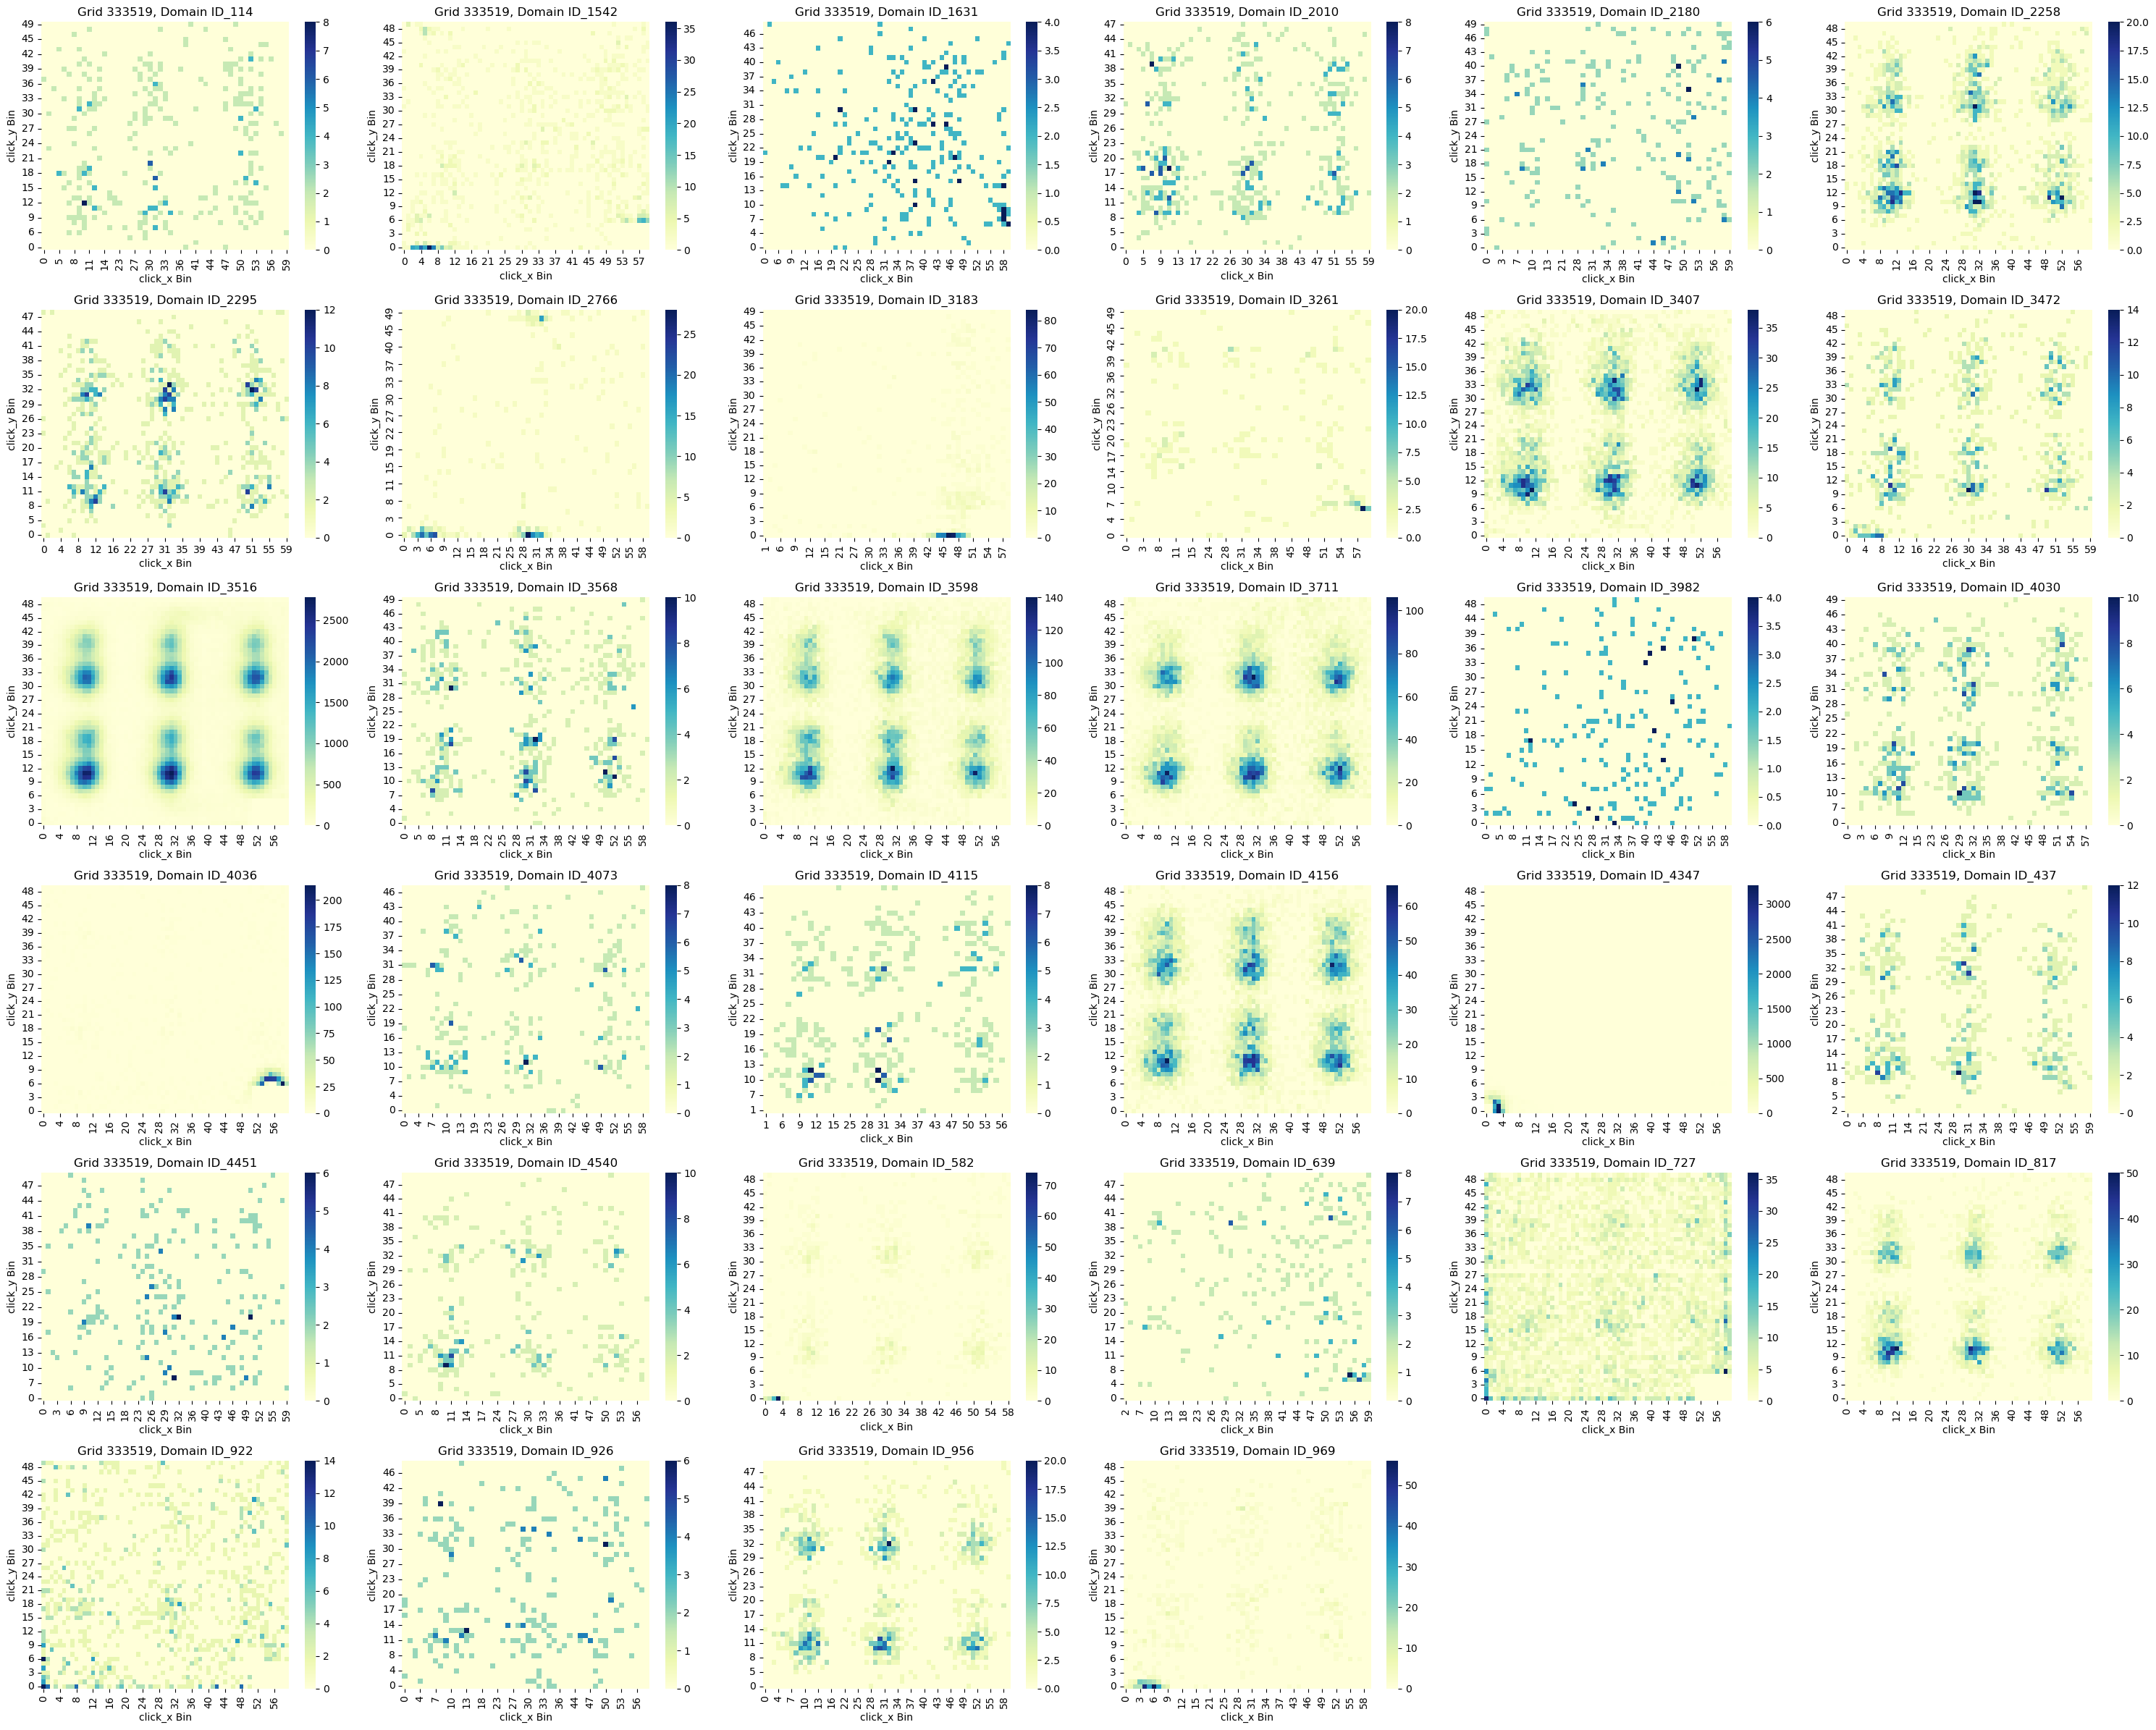

In [28]:
# plot predicted broken banners with grid_id = 333519

# Determine the number of unique pairs of (grid_id, domain)
n_unique_pairs = anomalies_clicks_519.groupby(['grid_id', 'domain']).ngroups

# Decide on the layout of the subplots (for example, a grid of 5x5 subplots if there are 25 unique pairs)
n_rows = int(np.ceil(np.sqrt(n_unique_pairs)))
n_cols = int(np.ceil(n_unique_pairs / n_rows))

# Create a large figure to accommodate all the subplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Iterate over each group, creating a subplot for each
for i, ((grid_id, domain), group) in enumerate(anomalies_clicks_519.groupby(['grid_id', 'domain']), start=1):
    click_matrix = group.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    # Create a subplot for the current heatmap
    ax = plt.subplot(n_rows, n_cols, i)
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=False, cbar=True, fmt="g", ax=ax)
    ax.set_title(f'Grid {grid_id}, Domain {domain}')
    ax.set_xlabel('click_x Bin')
    ax.set_ylabel('click_y Bin')
    ax.invert_yaxis() 

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


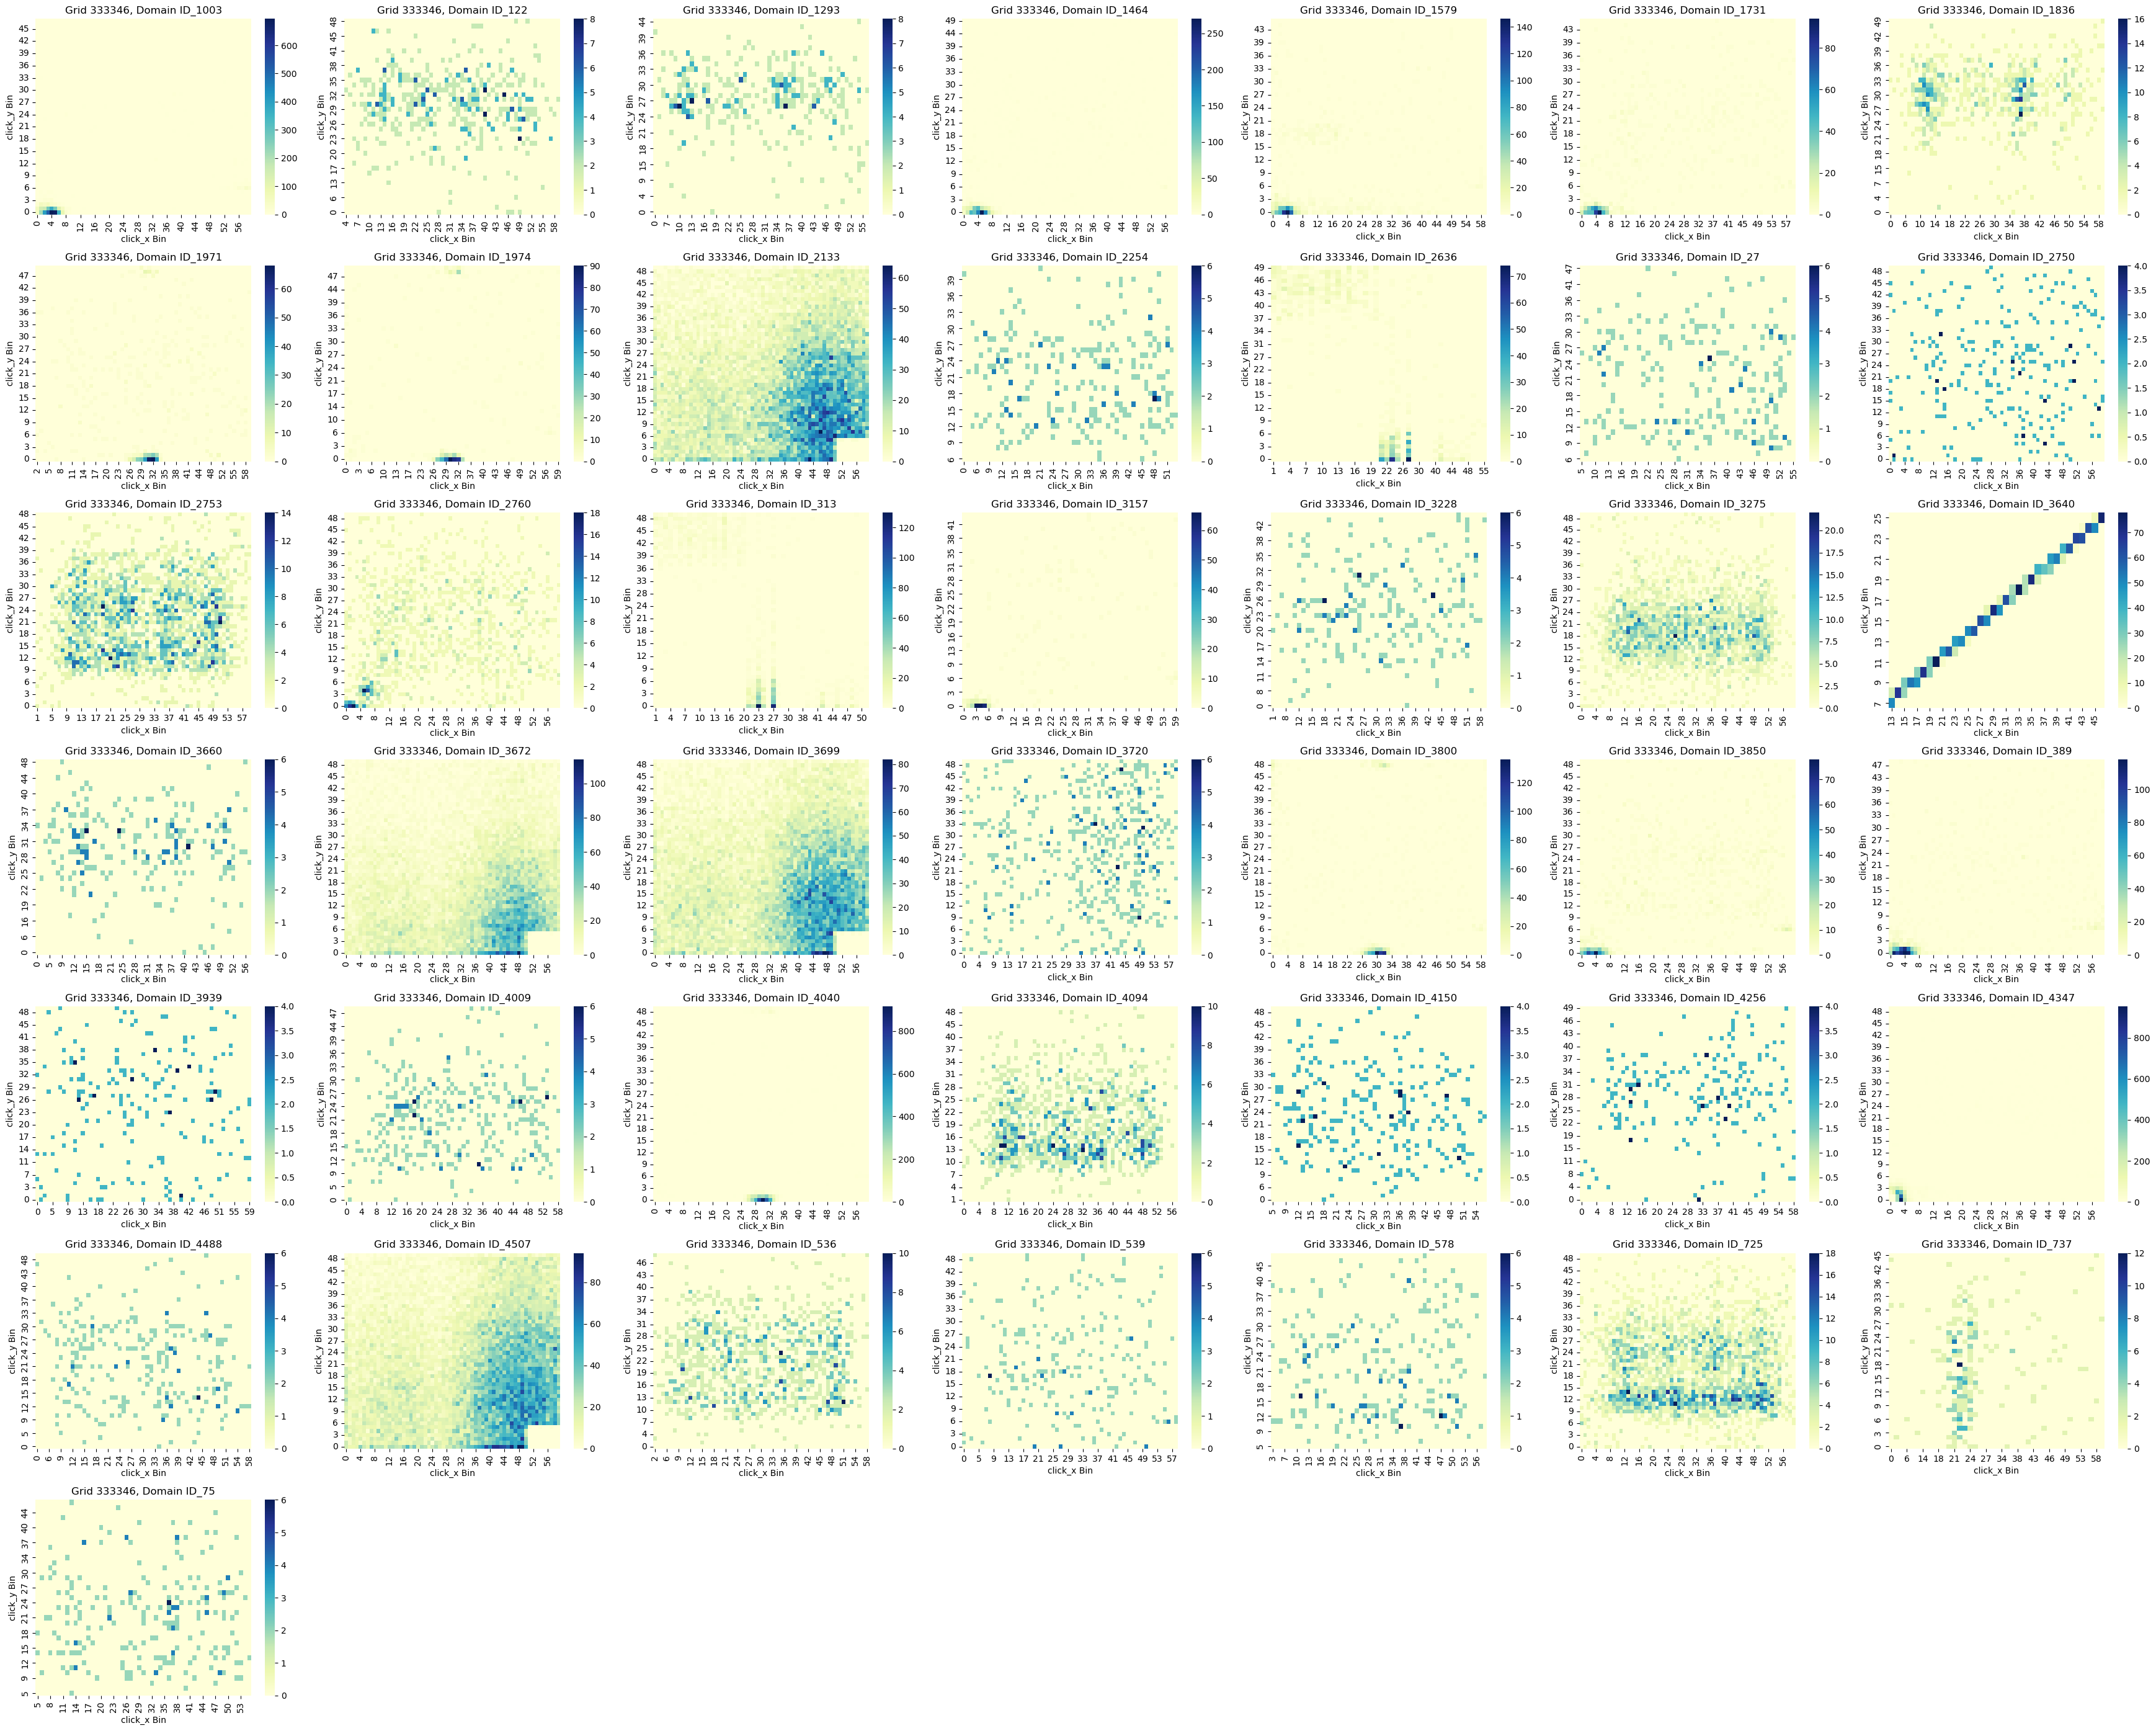

In [29]:
# plot predicted broken banners with grid_id = 333346

# Determine the number of unique pairs of (grid_id, domain)
n_unique_pairs = anomalies_clicks_346.groupby(['grid_id', 'domain']).ngroups

# Decide on the layout of the subplots (for example, a grid of 5x5 subplots if there are 25 unique pairs)
n_rows = int(np.ceil(np.sqrt(n_unique_pairs)))
n_cols = int(np.ceil(n_unique_pairs / n_rows))

# Create a large figure to accommodate all the subplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Iterate over each group, creating a subplot for each
for i, ((grid_id, domain), group) in enumerate(anomalies_clicks_346.groupby(['grid_id', 'domain']), start=1):
    click_matrix = group.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    # Create a subplot for the current heatmap
    ax = plt.subplot(n_rows, n_cols, i)
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=False, cbar=True, fmt="g", ax=ax)
    ax.set_title(f'Grid {grid_id}, Domain {domain}')
    ax.set_xlabel('click_x Bin')
    ax.set_ylabel('click_y Bin')
    ax.invert_yaxis() 

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()
